### `Prediction of Early Hospital Readmission of Diabetic patients`

## Table of Content

1. **[Import Libraries](#lib)**
2. **[Exploratory Data Analysis](#EDA)**
    - 2.1 - **[Understand the Data](#read)**
    - 2.2 - **[Data-preprocessing](#preprocess)**
    - 2.3 - **[Missing Value Analysis](#null)**
    - 2.4 - **[Analysis of Target variable](#Target)**
    - 2.5 - **[Univariate Analysis & Bivariate Analysis](#analysis)**
    - 2.6 - **[Outlier Analysis](#outlier)**

<a id="lib"></a>
## Importing Liabraries

In [ ]:
from warnings import filterwarnings
filterwarnings(action='ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures,PowerTransformer,StandardScaler

from sklearn.pipeline import Pipeline,make_pipeline

from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.impute import KNNImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier

from imblearn.over_sampling import SMOTE,SMOTEN,SMOTENC

In [ ]:
data = pd.read_csv('diabetic_data_orignal.csv')
admission_type = pd.read_excel('Mapping.xlsx',sheet_name='Admission_type_id')
discharge_disposition = pd.read_excel('Mapping.xlsx',sheet_name='Discharge_disposition')
admission_source = pd.read_excel('Mapping.xlsx',sheet_name='Admission_source_id')

SyntaxError: ignored

In [ ]:
df = data.copy()

<a id="EDA"></a>
# Exploratory Data Analysis

<a id="read"></a>
## 1) Data understaning

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.iloc[:,0:10].head(3)

In [ ]:
df.iloc[:,10:19].head(3)

In [ ]:
df.iloc[:,19:31].head(3)

In [ ]:
df.iloc[:,31:45].head(3)

In [ ]:
df.iloc[:,45:55].head(3)

<a id="preprocess"></a>
## 2) Data-preprocessing

In [ ]:
df = df.rename(columns={'diag_1':'diagnosis_1','diag_2':'diagnosis_2','diag_3':'diagnosis_3'})

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0]

In [ ]:
# There are no null values, but let's check for '?'

In [ ]:
print("Total columns with null values :",df.isin(['?']).sum()[df.isin(['?']).sum() > 0].count())
print("")
print(df.isin(['?']).sum()[df.isin(['?']).sum() > 0])

In [ ]:
df = df.replace(to_replace='?',value=np.nan)

In [ ]:
# Removing 'Encounter_id','patient_no','payer_code' as these do not influence 're-admission'
feature_removal = ['encounter_id', 'patient_nbr','payer_code']
df = df.drop(columns=feature_removal)

<a id="null"></a>
## 3) Missing values Analysis

In [ ]:
def nullvalues(data):
    columns = data.columns.tolist()
    return {col : data[col].isnull().sum() for col in columns if data[col].isnull().sum() > 0}
null_dict = nullvalues(df)

print(null_dict)

null_df = pd.Series(null_dict).to_frame().reset_index().rename(columns={0:'Null_values'})

In [ ]:
null_df.sort_values(by=['Null_values'],ascending=True).set_index('index').plot(kind='barh'
                                                                               ,color='green',
                                                                              figsize=(5,5))
plt.title("Null value count")
plt.ylabel("Attribute")
plt.legend(loc='center right')
plt.show()

In [ ]:
# Lets visualize null values

plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(),cmap='YlGnBu')
plt.show()

In [ ]:
def Description(data):
    """return dataframe of describing all Attributes
    """
    data_dict = {'Attribute' : data.columns,
                 'Data_type' : [data[column].dtype.name for column in data.columns],
                 'Total_Entries' : [data.shape[0]]*len(data.columns),
                 'Null_values' : data.isnull().sum().values,
                 'Percent_Null_values' : (data.isnull().mean().round(4) * 100).values,
                 'Unique_values' : data.nunique().values} 
    data_details = pd.DataFrame(data_dict)
    return data_details
data_desc = Description(df)

# Top 7 attributes which contain Null values

data_desc.sort_values(by=['Percent_Null_values'],ascending=False,ignore_index=True).head(7)

In [ ]:
# The attribute which does not give any information,which are going to be removed

data_desc[data_desc['Unique_values'] == 1]

<a id="Target"></a>
## 4) Analysis of Target variable

In [ ]:
# Target contains no null values
# since we are interested in the objective i.e 'Early Readmission' or 'No-early-readmission'
# we will consider '<30' as 'Readmission' and ['>30','No'] as 'No_Readmission'
# we will encode Readmission = 'Yes', No_Readmission = 'No' 

df['readmitted'] = df['readmitted'].map({'<30':'Yes','>30':'No','NO':'No'})

plt.figure(figsize=(5,5))
sns.countplot(df['readmitted'],palette='magma')
plt.ylabel("Number of counts",fontsize=12)
plt.xlabel("Status",fontsize=12)
plt.show()

<a id="analysis"></a>
## 5) Univariate & Bivariate analysis

### `Race`

In [ ]:
sns.countplot(y = df['race'],hue=df['readmitted'],palette='magma')
plt.title("Distribution of Races w.r.t Re-admission")
plt.ylabel("Race")
plt.show()

In [ ]:
# from above plot, we can infer that caucasians and AfricanAmericans have 
# high re-admission rate

In [ ]:
fig,ax = plt.subplots(figsize=(6,5))
sns.countplot(data=df,x='gender',hue=df['readmitted'],palette='magma')
plt.xlabel("gender",labelpad=15.0)
plt.ylabel("count",labelpad=15.0)
plt.legend(loc='upper right')
plt.show()

### `Age`

In [ ]:
sns.countplot(y=df['age'],hue=df['readmitted'],palette='magma')
plt.title("Number of patients from different Age group")
plt.show()

In [ ]:
# from above plot we can say most number of patients admissions are in the age range of 40-100
# people who are between age 70-80 have highest inpatient encounter as well as re-admission rate

### mapping -
### 1) Admission_type_id
### 2) Admission_source_id
### 3) Discharge_disposition_id

In [ ]:
mapping_1 = dict(zip(discharge_disposition.discharge_disposition_id.values,
                     discharge_disposition.description.values))
mapping_2 = dict(zip(admission_type.admission_type_id.values,admission_type.description.values))
mapping_3 = dict(zip(admission_source.admission_source_id.values,
                     admission_source.description.values))

In [ ]:
df.discharge_disposition_id = df.discharge_disposition_id.map(mapping_1).astype('string')
df.admission_type_id = df.admission_type_id.map(mapping_2).astype('string')
df.admission_source_id = df.admission_source_id.map(mapping_3).astype('string')

### `Admission source`

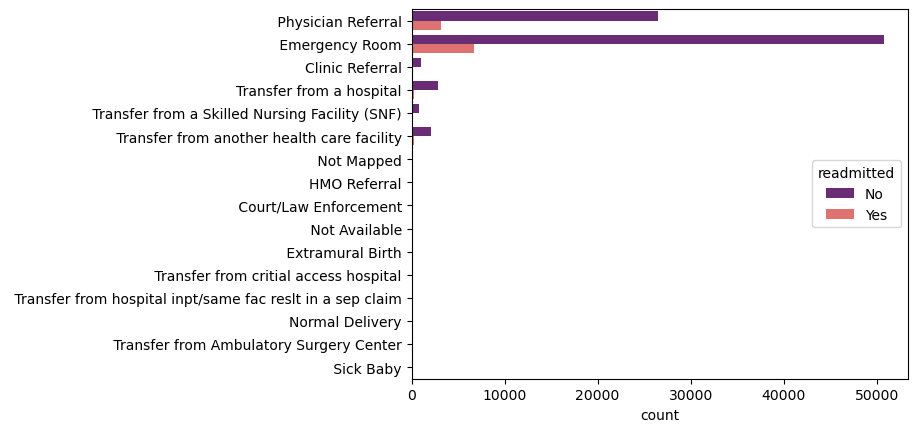

In [ ]:
sns.countplot(y=df['admission_source_id'],hue=df['readmitted'],palette='magma')
plt.ylabel("")
plt.show()

### `Admission type`

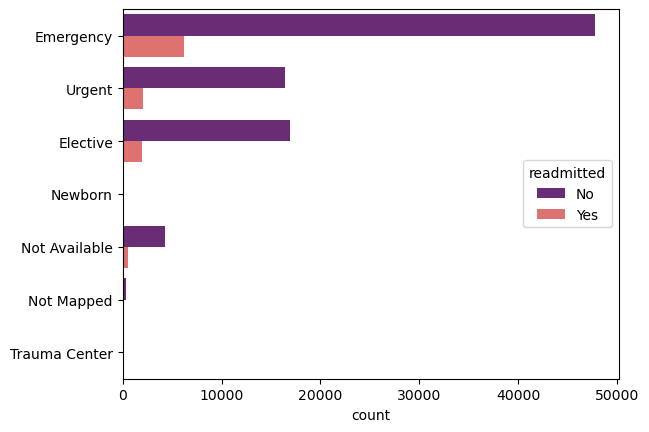

In [ ]:
sns.countplot(y=df['admission_type_id'],hue=df['readmitted'],palette='magma')
plt.ylabel("")
plt.show()

### `Discharge disposition`

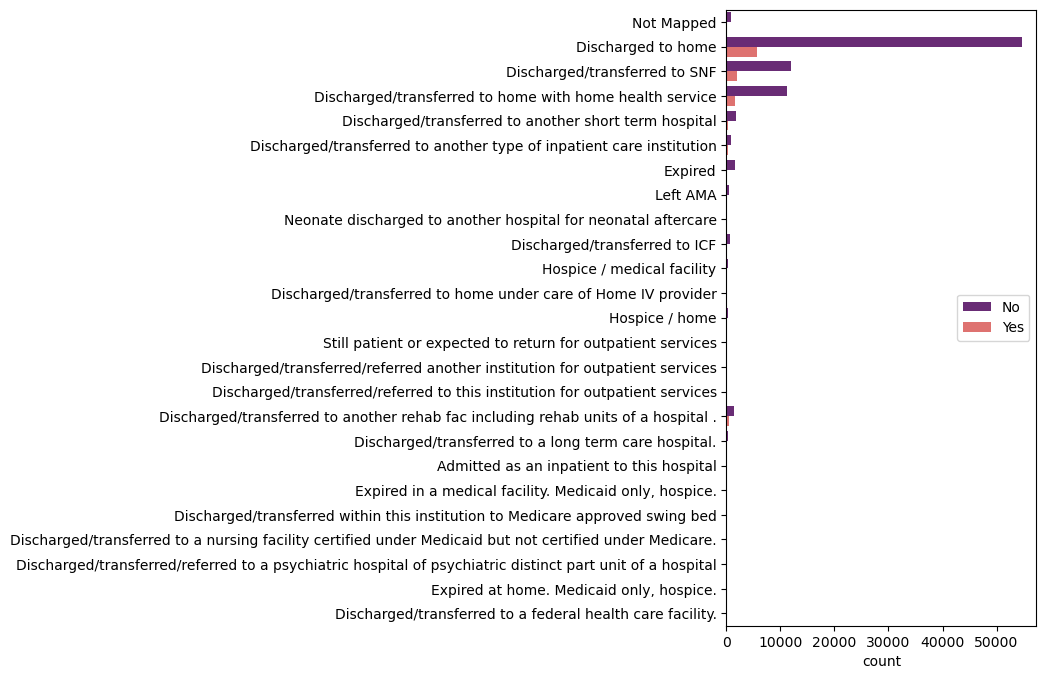

In [ ]:
plt.figure(figsize=(4,8))
sns.countplot(y=df['discharge_disposition_id'],hue=df['readmitted'],palette='magma')
plt.ylabel("")
plt.legend(loc='center right')
plt.show()

### `Time in hospital`

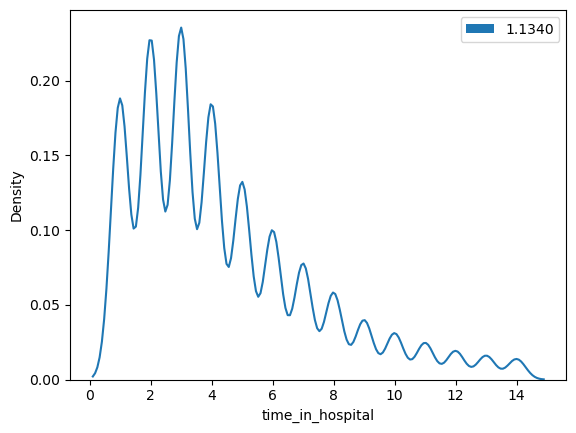

In [ ]:
sns.kdeplot(df['time_in_hospital'])
skewness_time = f"{df['time_in_hospital'].skew():0.4f}"
kde_patch = mpatches.Patch(label=skewness_time)
plt.legend(handles=[kde_patch])
plt.show()

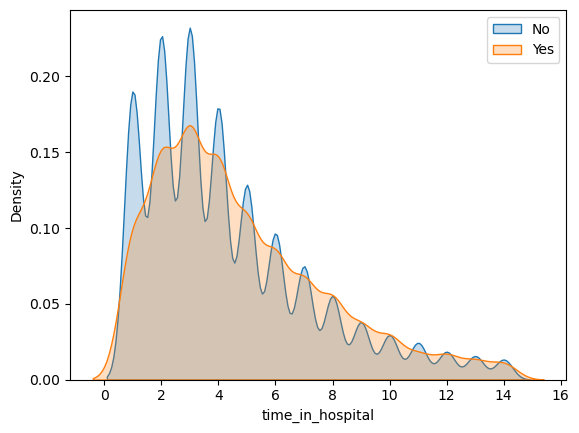

In [ ]:
for category in df.readmitted.unique():
    sns.kdeplot(df[df['readmitted'] == category]['time_in_hospital'],
                fill=True,palette='viridis',label=category)
plt.legend()
plt.show()

In [ ]:
stats.shapiro(df['time_in_hospital'])

### `Medical speciality (Top 10)`

In [ ]:
# percentage null values in Medical speciality

np.round(df['medical_specialty'].isnull().sum()*100/df['medical_specialty'].shape[0],2)

49.08

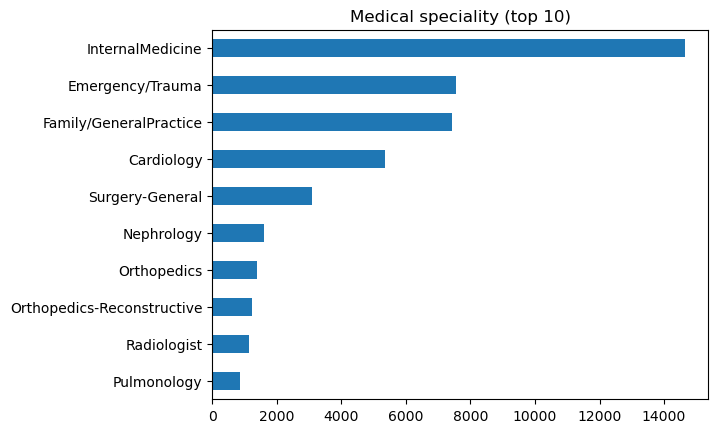

In [ ]:
df.medical_specialty.value_counts().nlargest(10).sort_values().plot(kind='barh')
plt.title("Medical speciality (top 10)",fontsize=12)
plt.show()

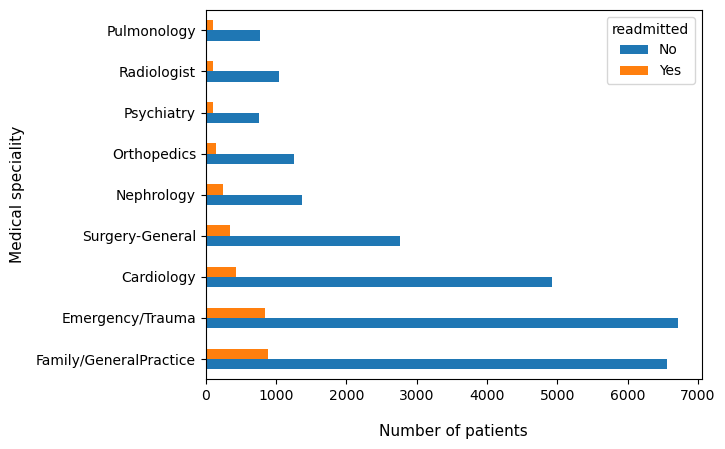

In [ ]:
pd.crosstab(df['medical_specialty'],
            df['readmitted']).sort_values(by=['Yes'],ascending=0).iloc[1:10].plot(kind='barh')
plt.xlabel("Number of patients",fontsize=11,labelpad=15)
plt.ylabel("Medical speciality",fontsize=11,labelpad=8)
plt.show()

### `No of lab procedures`

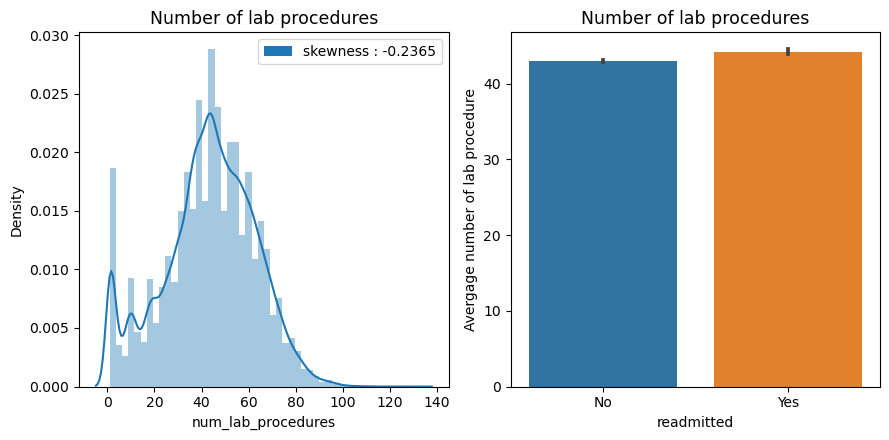

In [ ]:
skewness_lab_pro = f"skewness : {df['num_lab_procedures'].skew():0.4f}"
kde_patch_lab_pro = mpatches.Patch(label=skewness_lab)

fig,ax = plt.subplots(1,2,figsize=(9,4.5))

ax[0] = sns.distplot(df['num_lab_procedures'],ax=ax[0])
ax[0].set_title("Number of lab procedures",fontsize=12.5)
ax[0].legend(handles=[kde_patch_lab_pro])

ax[1] = sns.barplot(data=df,x='readmitted',y='num_lab_procedures',ax=ax[1])
ax[1].set_ylabel("Avergage number of lab procedure")
ax[1].set_title("Number of lab procedures",fontsize=12.5)

plt.tight_layout()
plt.show()

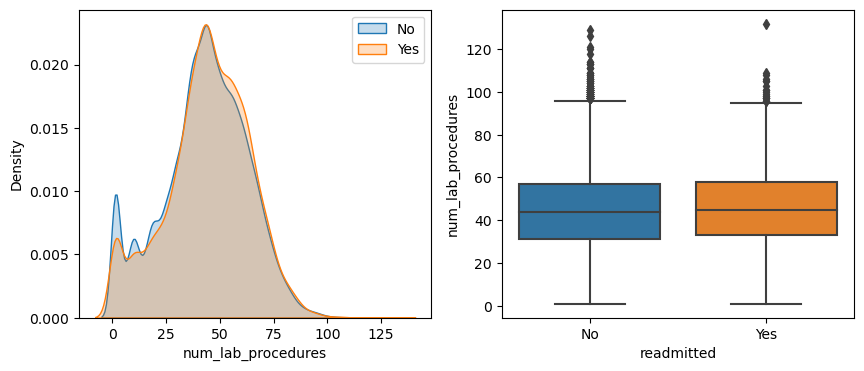

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
for category in df.readmitted.unique():
    sns.kdeplot(df[df['readmitted'] == category]['num_lab_procedures'],
                fill=True,palette='viridis',label=category,ax=ax[0])
ax[0].legend()

sns.boxplot(data=df,x='readmitted',y='num_lab_procedures',ax=ax[1])
plt.show()

### `No of procedures (Procedures other than lab procedures)`

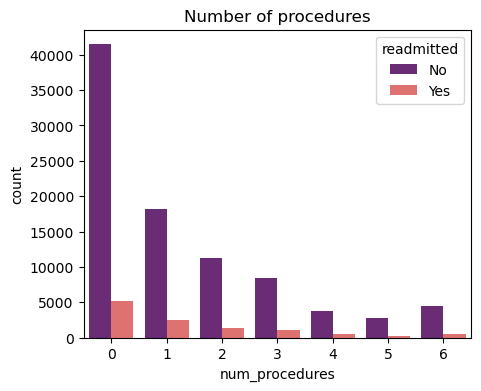

In [ ]:
fig,ax = plt.subplots(figsize=(5,4))
ax = sns.countplot(df['num_procedures'],hue=df['readmitted'],palette='magma')
ax.set_title("Number of procedures")
plt.show()

### `Number of Medications`

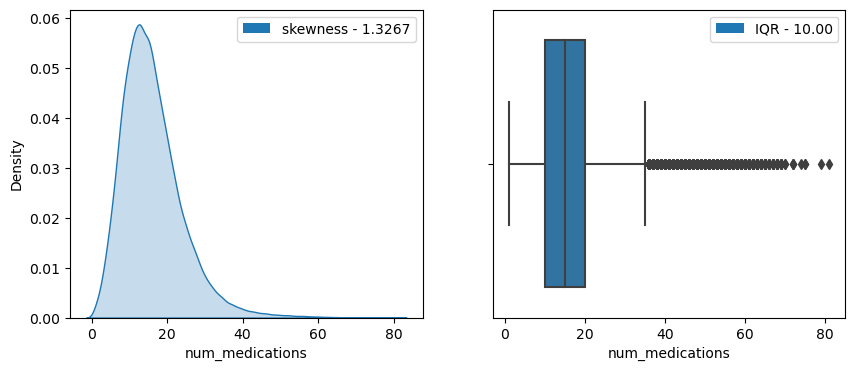

In [ ]:
IQR = stats.iqr(df['num_medications'])
skewness = f"skewness - {df['num_medications'].skew():0.4f}"
IQR = f"IQR - {IQR:0.2f}"
fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.kdeplot(df['num_medications'],ax=ax[0],fill=True)
kde_patch = mpatches.Patch(label=skewness)
box_patch = mpatches.Patch(label=IQR)
ax[0].legend(handles=[kde_patch])
ax[1].legend(handles=[box_patch])
sns.boxplot(df['num_medications'],ax=ax[1])
plt.show()

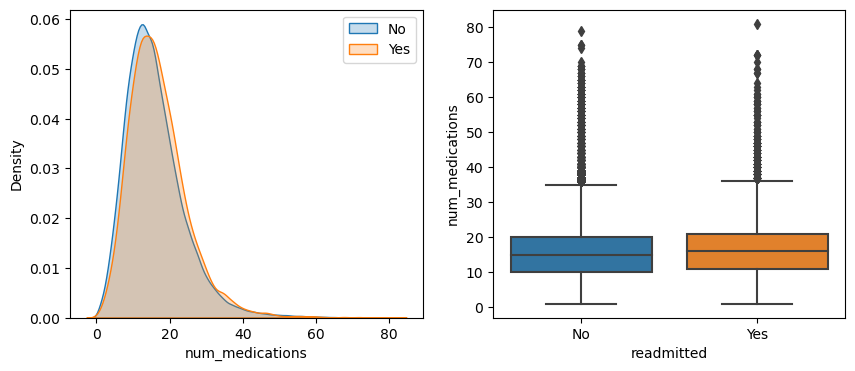

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
for category in df.readmitted.unique():
    sns.kdeplot(df[df['readmitted'] == category]['num_medications'],
                fill=True,palette='viridis',label=category,ax=ax[0])
ax[0].legend()

sns.boxplot(data=df,x='readmitted',y='num_medications',ax=ax[1])
plt.show()

### `Inpatient & Outpatient encounters before present encounter`
### `(visualizing upto 6 visits)`

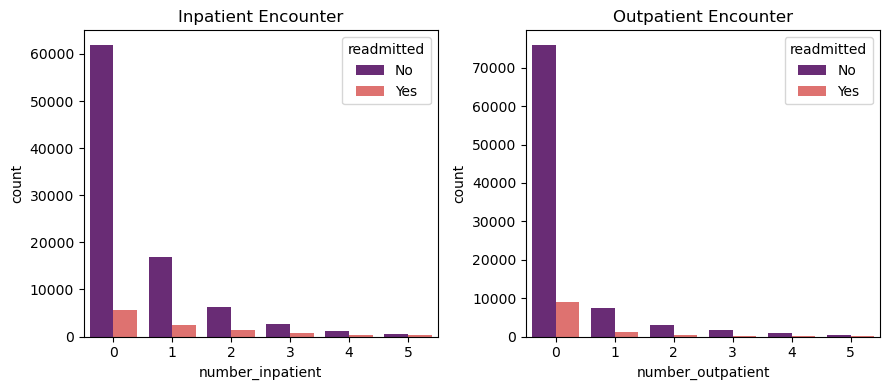

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(9,4))
sns.countplot(df['number_inpatient'][df['number_inpatient'].isin([*range(6)])],
             hue=df['readmitted'],ax=ax[0],palette='magma')
ax[0].set_title("Inpatient Encounter")
ax[1].set_title("Outpatient Encounter")
sns.countplot(df['number_outpatient'][df['number_outpatient'].isin([*range(6)])],
             hue=df['readmitted'],ax=ax[1],palette='magma')
plt.tight_layout()
plt.show()

In [ ]:
# Visualizing upto 5 Inpatient and outpatient encounters
# Since we are interested in only early re-admission rates (<30 days)
# Observations says 0 or 1 previous Inpatient encounters have high re-admission rate 
# Observations says 0 previous Outpatient encounters have high re-admission rate
# People having prior significant Inpatient/Outpatient encounters have less chance of getting readmitted 
# be it less than 30 days or greater than 30 days
# Hospital administration might have taken Post-Hospitalization steps to prevent re-admission
# But the early re-admission (<30) is a area of interest.

### `Number of Emergency visits before the encounter`

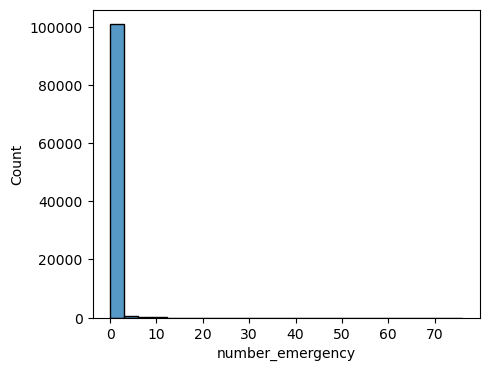

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.histplot(df['number_emergency'],bins=25)
plt.show()

### `Diagnosis (1,2 & 3)`

In [ ]:
# Converting all strings to -1 to make attribute homogeneous
# Converting these columns to float64 datatype

diagnosis = ['diagnosis_1','diagnosis_2','diagnosis_3']
for diag in diagnosis:
    df[diag].loc[df[diag].astype('string').str.contains('[A-Za-z].+[0-9]*')] = -1
    df[diag] = df[diag].astype(np.float64)

In [ ]:
def diagnosis_encoding(x):
    if (x >= 140 and x <= 239):
        return 'Neoplasms'
    elif x == 785 or (x >=390 and x <= 459):
        return 'circulatory'
    elif x == 786 or (x >= 460 and x <= 519):
        return 'Respiratory'
    elif x == 787 or (x >= 520 and x <= 579):
        return 'Digestive'
    elif x >= 250 and (x >= 250 and x <= 251):
        return 'Diabetes'
    elif x >= 800 and x <= 1000:
        return 'Injury'
    elif x >= 710 and x <= 739:
        return 'Musculoskeletal'
    elif (x >=580 and x <= 629) or x == 788: 
        return 'Genitourinary'
    elif x == -1:
        return 'other'
    elif pd.isnull(x):
        return np.nan
    else: 
        return 'other'

In [ ]:
# Applying function to primary, secondary and Additional secondary diagnosis

diagnosis = ['diagnosis_1','diagnosis_2','diagnosis_3']
for diag in diagnosis:
    df[diag] = df[diag].apply(diagnosis_encoding)

In [ ]:
# checking null values in primary diagnosis,secondary,Additional secondary diagnostics
imputation = ['diagnosis_1','diagnosis_2','diagnosis_3','readmitted']
df[imputation].isnull().sum()

diagnosis_1      21
diagnosis_2     358
diagnosis_3    1423
readmitted        0
dtype: int64

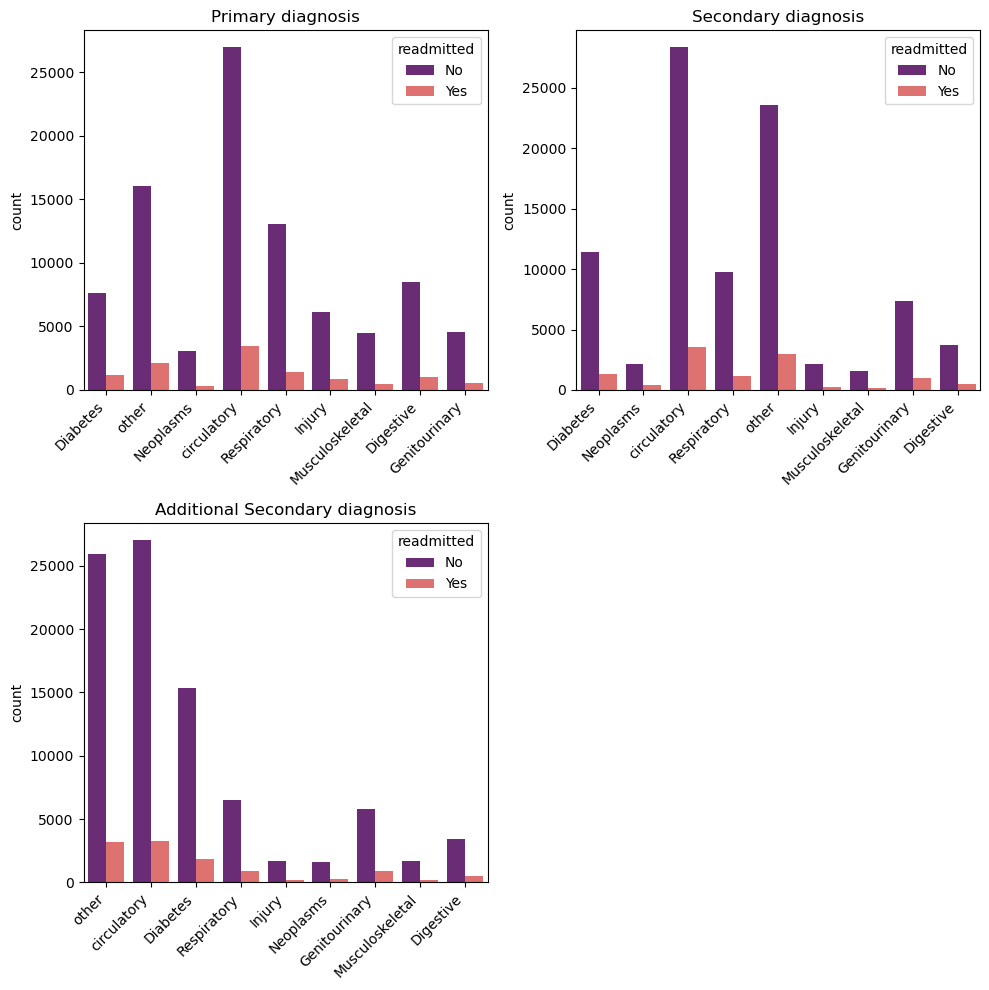

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.countplot(df['diagnosis_1'],hue=df['readmitted'],palette='magma')
plt.title("Primary diagnosis")
plt.xlabel("")
plt.xticks(rotation=45,ha='right')

plt.subplot(222)
sns.countplot(df['diagnosis_2'],hue=df['readmitted'],palette='magma')
plt.title("Secondary diagnosis")
plt.xticks(rotation=45,ha='right')
plt.xlabel("")

plt.subplot(223)
sns.countplot(df['diagnosis_3'],hue=df['readmitted'],palette='magma')
plt.title("Additional Secondary diagnosis")
plt.xticks(rotation=45,ha='right')
plt.xlabel("")

plt.tight_layout()
plt.show()

### `Number of diagnosis`

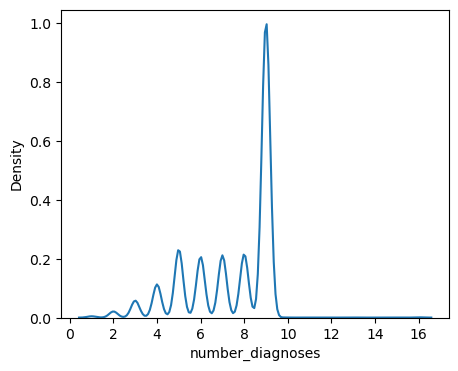

In [ ]:
fig,ax = plt.subplots(figsize=(5,4))
sns.kdeplot(df['number_diagnoses'])
plt.show()

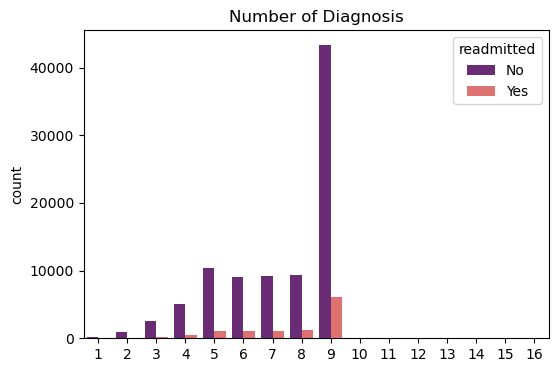

In [ ]:
# Above data does not follow normality

plt.figure(figsize=(6,4))
sns.countplot(data=df,x='number_diagnoses',hue='readmitted',palette='magma')
plt.title("Number of Diagnosis")
plt.xlabel("")
plt.show()

### `Max_glucose_serum`

In [ ]:
df['max_glu_serum'].unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

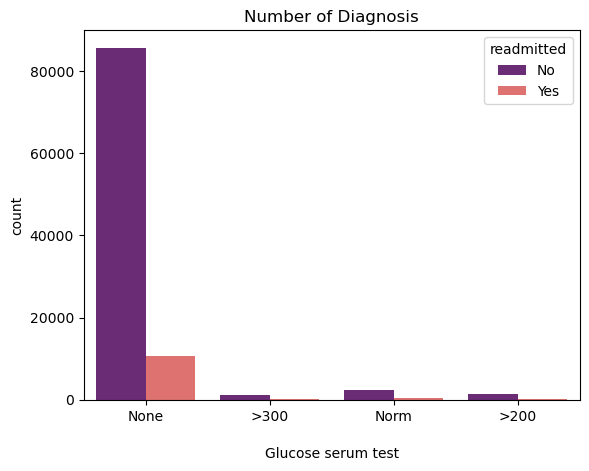

In [ ]:
sns.countplot(df['max_glu_serum'],hue=df['readmitted'],palette='magma')
plt.title("Number of Diagnosis")
plt.xlabel("Glucose serum test",labelpad=17)
plt.show()

In [ ]:
# Inpatient encounters Glucose serum test has not been done, more cases of early re-admission

### `A1c_result`

In [ ]:
df['A1Cresult'].value_counts()

None    84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

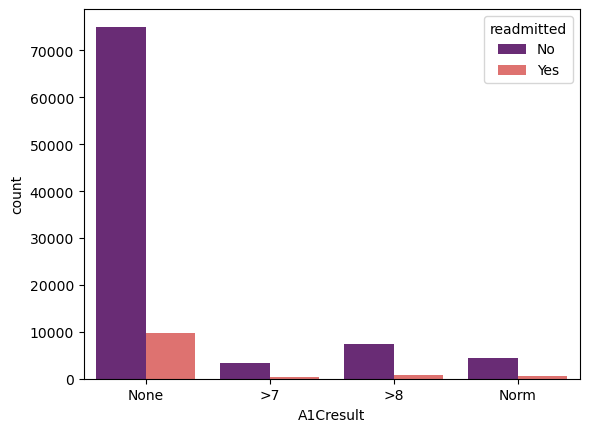

In [ ]:
sns.countplot(df['A1Cresult'],hue=df['readmitted'],palette='magma')
plt.show()

In [ ]:
# from above observation it shows that peope who have not undergone HBA1c test,
# they have high re-admission probability.
# also compared to '>7','Norm' the people who have '>8' HBA1c result have slightly higher
# readmission probability.

### `Analysis of Medicine with respect to Admission`

In [ ]:
# taking all attribute related to medicine, target - readmitted

medicine = df[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']]

In [ ]:
feature_medicine = medicine.columns

In [ ]:
# let us know categories in attributes related to Medicine
# constructing a dataframe by creating a dictionary except taregt.

med = dict()
for i in medicine.columns:
    med[i] = medicine[i].value_counts().to_dict()
medicine_info = pd.DataFrame(med).swapaxes(1,0)
medicine_info = medicine_info.fillna(0).astype(np.int32).rename({'No':'Not taking'},axis=1)

In [ ]:
medicine_info.columns

Index(['Not taking', 'Steady', 'Up', 'Down'], dtype='object')

In [ ]:
def skewed_levels_row(row):    
    highlight = 'background-color: palegreen;'
    default = ''
    minimum_in_row = 5
    if row.sum() <= 5:
        return [highlight if v <= minimum_in_row else default for v in row]
    else:
        return [default for v in row]
medicine_info.style.apply(skewed_levels_row, subset=['Steady', 'Up', 'Down'], axis=1)

In [ ]:
# The numbers which are highlighted in green are the attributes which are 
# 1) Too much skewed 
# 2) containing very few among 'steady','up' & 'down'
# 3) So we will drop 7 features out of 23 medicinal attributes

In [ ]:
column_1 = lambda x : np.round((x.sum(axis=1)/medicine.shape[0]),2)*100
column_2 = np.round((medicine_info['Not taking']*100/medicine.shape[0]),2)

# creating 2 columns
medicine_info = medicine_info[['Steady','Up','Down']].assign(taking = column_1,
                                                             not_taking=column_2)

In [ ]:
medicine_info

Steady     Up   Down  taking  not_taking
metformin                  18346   1067    575    20.0       80.36
repaglinide                 1384    110     45     2.0       98.49
nateglinide                  668     24     11     1.0       99.31
chlorpropamide                79      6      1     0.0       99.92
glimepiride                 4670    327    194     5.0       94.90
acetohexamide                  1      0      0     0.0      100.00
glipizide                  11356    770    560    12.0       87.53
glyburide                   9274    812    564    10.0       89.53
tolbutamide                   23      0      0     0.0       99.98
pioglitazone                6976    234    118     7.0       92.80
rosiglitazone               6100    178     87     6.0       93.75
acarbose                     295     10      3     0.0       99.70
miglitol                      31      2      5     0.0       99.96
troglitazone                   3      0      0     0.0      100.00
tolazamide                    38      1      0     0.0       99.96
examide                        0      0      0     0.0      100.00
citoglipton                    0      0      0     0.0      100.00
insulin                    30849  11316  12218    53.0       46.56
glyburide-metformin          692      8      6     1.0       99.31
glipizide-metformin           13      0      0     0.0       99.99
glimepiride-pioglitazone       1      0      0     0.0      100.00
metformin-rosiglitazone        2      0      0     0.0      100.00
metformin-pioglitazone         1      0      0     0.0      100.00

### `Analysis of Medicinal attributes`

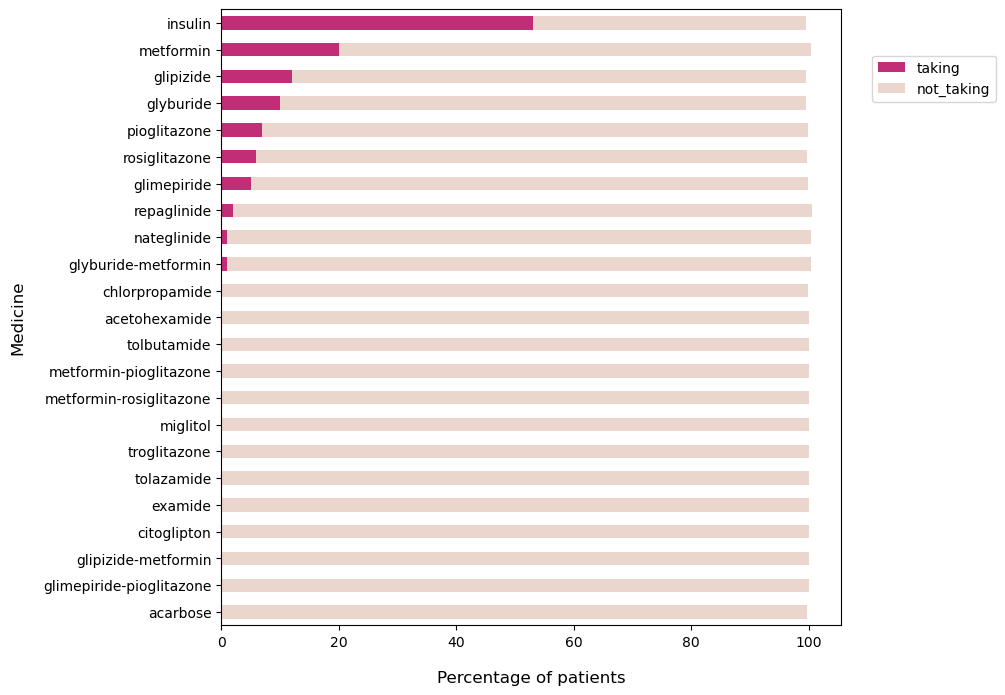

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
medicine_info[['taking','not_taking']].sort_values(by=['taking']).plot(kind='barh',stacked=True,
                                            color=['#C22D78','#EBD6CD'],ax=ax)

ax.set_xlabel("Percentage of patients",labelpad=15,fontsize=12)
ax.set_ylabel("Medicine",labelpad=13,fontsize=12)

ax.legend(loc=(1.05,0.85))
plt.show()

In [ ]:
# clearly we can see the zero values in some medicines which means 
# Some medicines are not at all taken by any patients.
# or very few value_counts, which will not give any information.

In [ ]:
# steady, up & down means patient has consumed medicine

### `HBA1c`

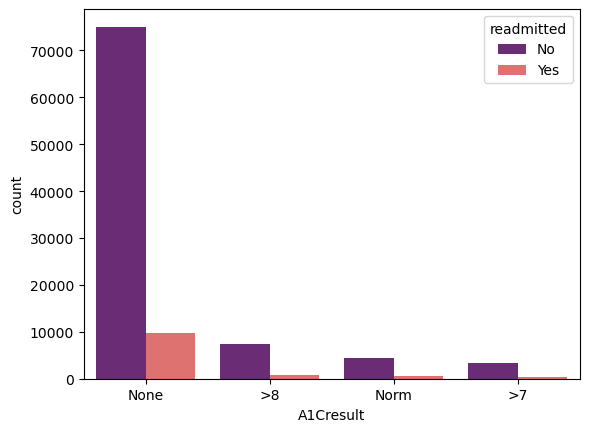

In [ ]:
ordering = df['A1Cresult'].value_counts(ascending=False).index
sns.countplot(data=df,x='A1Cresult',hue=df['readmitted'],order=ordering,palette='magma')
plt.show()

In [ ]:
# People who have not undergone HBA1c test are more likely to be readmitted to hospital.
# Hence it's more important observation that 'HBA1c' is important factor for readmission

### `Change`

In [ ]:
# Change of diabetic medication

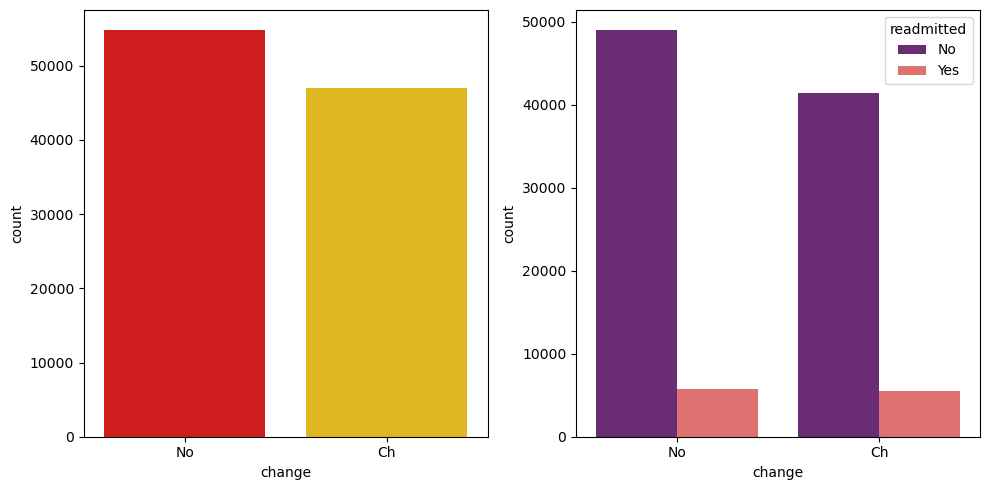

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.countplot(df['change'],palette='hot',ax=ax[0])
sns.countplot(df['change'],palette='magma',hue=df['readmitted'],ax=ax[1])
plt.tight_layout()
plt.show()

### HBA1c with change

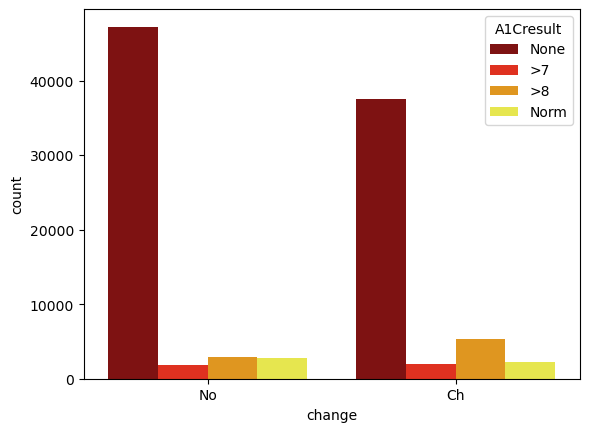

In [ ]:
sns.countplot(df['change'],palette='hot',hue=df['A1Cresult'])
plt.show()

## `Diabetes Med`

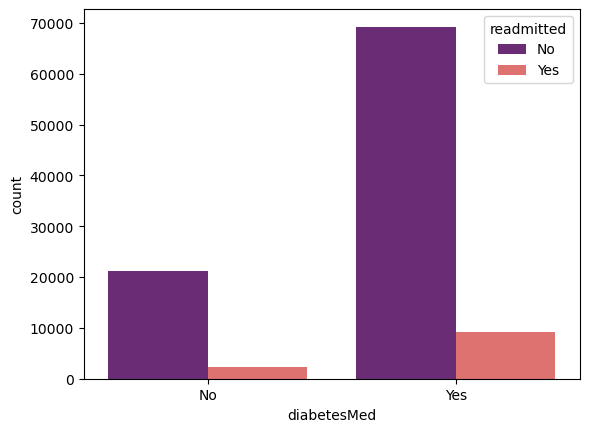

In [ ]:
sns.countplot(df['diabetesMed'],palette='magma',hue=df['readmitted'])
plt.show()

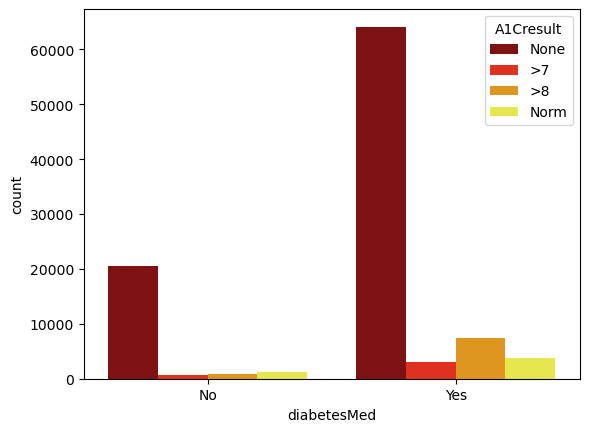

In [ ]:
sns.countplot(df['diabetesMed'],palette='hot',hue=df['A1Cresult'])
plt.show()

In [ ]:
# From above plot we can see that,medications have been changed for 
# have high readmission chances

### `Bivariate Analysis of numerical attributes`

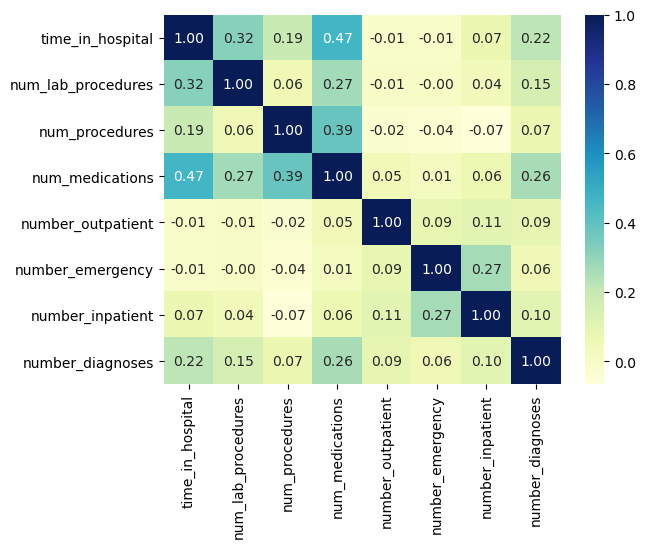

In [ ]:
sns.heatmap(df.select_dtypes(np.number).corr(),annot=True,fmt='0.2f',cmap='YlGnBu')
plt.show()

In [ ]:
# Function to look at outliers based on IQR and Z_score
# storing all the indexes of outliers in dictionary with their corresponding columns

def outliers(dataframe,feature,criteria ='IQR',threshold = 1.5):
    """criteria={'IQR','zscore'} default IQR"""
    if criteria in ['IQR','Iqr','iqr']:
        upper_limit = np.quantile(dataframe[feature],0.75) + threshold*iqr(dataframe[feature])
        lower_limit = np.quantile(dataframe[feature],0.25) - threshold*iqr(dataframe[feature])
        dframe = dataframe[(dataframe[feature] < lower_limit) | (dataframe[feature] > upper_limit)]
        return dframe.index
    elif criteria in ['zscore','Zscore','z-score','Z-score','Z']:
        df_z = ((dataframe[feature] - dataframe[feature].mean())/dataframe[feature].std())
        return df[(df_z < (-1*threshold)) | (df_z > threshold)].index
    else:
        return "Mention correct criteria"

In [ ]:
# time in hospital - Normally distributed
# num_lab_procedure - Normally distributed
# num_medications - Normally distributed

# num_procedures - not normally - descritize it
# number_outpatient - not normally - descritize it
# number_emergency - not normally - descritize it
# number_inpatient - not normally - descritize it
# number_diagnoses - not normally - descritize it